In [1]:
#%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np
import math


# 2. Two view Geometry

For this task, you have been given two images of the same scene taken from different view-points. Refer to below two images and follow the below points for deliverables:
<br>

*Note: For this question you will need to compute the F matrix on your own without using inbuilt functions. The convention used for F is $x'^{T}Fx$ where $x'$ is the **location of the point in the second image**. File `data/2/camera.txt` has camera parameters in order **Fx, Fy, Cx, Cy, Scaling factor***
<br>


<img src="./data/2/rgb000551.jpg" alt="image 1" width="400"/>
<img src="./data/2/rgb000841.jpg" alt="image 2" width="400"/>


1. Estimate the fundamental matrix from these two images. Clearly, write a function named `compute_fundamental_matrix(X1_list, X2_list)` that takes feature points from first image and corresponding points from second image i.e. known correspondences. You can compute the correspondences either using Feature detector-descriptor + Feature Matching algorithm from openCV or use code provided in DLT part i.e. handcraft them. Save the obtained matrix.

# TASKS

In [2]:
import cv2
import importlib
import matplotlib.pyplot as plt
import json
from copy import deepcopy
import numpy as np


In [3]:
import helper_utils.dlt_related as dlt_related
importlib.reload(dlt_related)
import helper_utils.annotate_images as img_helper
importlib.reload(img_helper)
import helper_utils.estimation_related as est_related
importlib.reload(est_related)

<module 'helper_utils.estimation_related' from '/home/anmolagarwal/Desktop/mr_assignment_3/helper_utils/estimation_related.py'>

### TODO 6:


2. What is cheirality condition and it's importance? Implement the following function for checking cheirality. `idx = CheckCheirality(Y,C,R)` Input: `Y` is a `n × 3` matrix that includes `n` 3D points, and `C,R` is the relative camera pose being checked(camera center and rotation). Output: `idx` is a set of indices of 3D points that satisfy cheirality.


### Ans:
Cheirality condition is the condition that the reconstructed points must be **in front of the cameras**. 

When a projective reconstruction of a scene is carried out from a set of point correspondences, an important piece of information is typically ignored – if the points are visible in the images, then they must have been in front of the camera.

When there are several potential camera poses a candidates, we can use the cheirality condition to eliminate some of the candidates.

The relation between P, K, R and C is:
$$P = KR\begin{bmatrix}I_{3\times3} & -C\end{bmatrix}$$

### TO test my approach:
* I generate a synthetic dataset which has: points in all 4 quadrants
* THen, I randomly rotate and translate the camera from the world origin and then generate the image such that some points fall behind and some points fall in the front.
* Using visualization, I am able to verify the correctness of my soln.

### Step 1: Put points in all the 4 quadrants for ease of visualization (synthetic dataset creation)

In [4]:
X_world = []

# 1st quadrant
NUM_PTS_PER_QUADRANT = 50

theta_arr = np.random.uniform(0,90,NUM_PTS_PER_QUADRANT)
z_arr = np.random.uniform(-20,20,NUM_PTS_PER_QUADRANT)
theta_arr[0] = 30
for (curr_angle, z) in zip(theta_arr, z_arr):
    x = 20 * np.cos(np.radians(curr_angle))
    y = 20 * np.sin(np.radians(curr_angle))
    X_world.append([x, y, z])
    

theta_arr = np.random.uniform(90,180,NUM_PTS_PER_QUADRANT)
z_arr = np.random.uniform(-20,20,NUM_PTS_PER_QUADRANT)

for (curr_angle, z) in zip(theta_arr, z_arr):
    x = 20 * np.cos(np.radians(curr_angle))
    y = 20 * np.sin(np.radians(curr_angle))
    X_world.append([x, y, z])
    
theta_arr = np.random.uniform(180,270,NUM_PTS_PER_QUADRANT)
z_arr = np.random.uniform(-20,20,NUM_PTS_PER_QUADRANT)

for (curr_angle, z) in zip(theta_arr, z_arr):
    x = 20 * np.cos(np.radians(curr_angle))
    y = 20 * np.sin(np.radians(curr_angle))
    X_world.append([x, y, z])
    
theta_arr = np.random.uniform(270,360,NUM_PTS_PER_QUADRANT)
z_arr = np.random.uniform(-20,20,NUM_PTS_PER_QUADRANT)

for (curr_angle, z) in zip(theta_arr, z_arr):
    x = 20 * np.cos(np.radians(curr_angle))
    y = 20 * np.sin(np.radians(curr_angle))
    X_world.append([x, y, z])
    
    
X_world=np.array(X_world)

In [5]:
X_world.shape

(200, 3)

#### The generated data points are (colored quadrant wise):

<IPython.core.display.Javascript object>


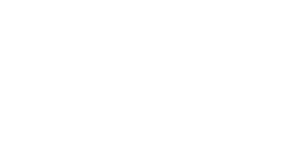

In [6]:
%matplotlib notebook

ax = plt.axes(projection='3d')

colors = ['red','blue','green','black']
for i in range(4):
    lb = i* NUM_PTS_PER_QUADRANT
    ub = lb + NUM_PTS_PER_QUADRANT
    xdata = X_world[lb:ub, 0]
    ydata = X_world[lb:ub, 1]
    zdata = X_world[lb:ub, 2]

    ax.scatter3D(xdata, ydata, zdata,c=colors[i])


##### Load the intrinsic camera matrix from the `data` folder


In [7]:
f_x = 382.1996765136719
f_y = 381.83956909
c_x = 312.7102355957031
c_y = 247.72047424316406
scaling_fac = 1000.0
K_mat = np.array([
    [f_x, scaling_fac, c_x,0],
    [0, f_y, c_y,0],
    [0, 0, 1,0]
    
])

In [8]:
from scipy.stats import ortho_group

#### Looking at the points

In [9]:
X_world[0]

array([17.32050808, 10.        , 14.0138544 ])

#### Deciding a custom value for `C` ie camera displacement wrt origin

In [10]:
C_vec = np.array([0, 10, 0])

In [11]:
theta_in_deg = 90
the_rad = np.radians(theta_in_deg)

In [12]:
np.random.seed(12)
R_z = np.array([
    [np.cos(the_rad), -np.sin(the_rad) , 0],
    [ np.sin(the_rad) ,  np.cos(the_rad)  ,  0 ],
    [ 0  , 0   ,  1  ]
    
    
])

R_z = np.array(ortho_group.rvs(dim=3))
print("Determinant is: ",np.linalg.det(R_z))

Determinant is:  0.9999999999999999


In [13]:
M_ext = np.zeros((4,4))
M_ext[0:3, 3]= -R_z@C_vec
#M_ext[0:3, 3]= -C_vec

M_ext[0:3, 0:3]= R_z
M_ext[-1, -1] = 1

In [14]:
with np.printoptions(suppress=True):
    print(C_vec)

[ 0 10  0]


In [15]:
with np.printoptions(suppress=True):
    print(M_ext)

[[ 0.54731351  0.83457107  0.0627619  -8.34571068]
 [-0.78850901  0.48906101  0.37292476 -4.89061008]
 [ 0.28053781 -0.25359508  0.9257365   2.53595078]
 [ 0.          0.          0.          1.        ]]


In [16]:
hom_X_world = []
for curr_elem in X_world:
    x, y, z = curr_elem
    hom_X_world.append([x, y, z, 1])
hom_X_world = np.array(hom_X_world)

In [17]:
hom_X_world[0]

array([17.32050808, 10.        , 14.0138544 ,  1.        ])

In [18]:
hom_X_world.shape

(200, 4)

In [19]:
M_ext.shape

(4, 4)

#### Transform the points from world coordinate frame to camera coordinate frame

Knowing M_ext, we can transfer points from world coordinate frame to camera coordinate frame. This is helpful as (the camera lies in it's xy plane of it's own frame and hence, the z-coordinate of points in camera's frame can be used to determine whether the point is in front of camera or behind.


In fact, we can then check the sign of the depth $Z$ in the camera coordinate system w.r.t. camera center. A 3D point X is in front of the camera iff: $r3(X−C)>0$ where $r3$ is the third row of the rotation matrix (z-axis of the camera). We also ensure that $X3 > 0$

In [20]:
transformed_world = M_ext@hom_X_world.T
transformed_world=transformed_world.T

In [21]:
X_world[0]

array([17.32050808, 10.        , 14.0138544 ])

In [22]:
for a in transformed_world:
    print(a)
    a/=a[-1]

[10.35928414 -8.43126343 17.83219404  1.        ]
[11.91271417 -5.00008017  9.39907851  1.        ]
[11.53448353 -5.40769484  0.09357235  1.        ]
[  6.8824318  -16.01298095  10.30975528   1.        ]
[11.28322047  6.782253   12.70405446  1.        ]
[10.93048729  0.1166002   0.39947652  1.        ]
[10.16794751  9.46521556 12.54236211  1.        ]
[11.74070585  2.43655178  8.89062531  1.        ]
[  7.88795309   0.17543654 -13.11095689   1.        ]
[  9.03709847 -18.13734532  -8.90741698   1.        ]
[ 10.1277911   -9.69558312 -17.95262419   1.        ]
[ 10.08477417 -12.53791322   3.94591253   1.        ]
[11.79011832 -5.73750312  9.56656355  1.        ]
[  9.71665665 -11.14295949  12.45937021   1.        ]
[11.62032876 -5.45603229  1.51290376  1.        ]
[11.01285793 -6.62364195 19.30689677  1.        ]
[11.25632669 -2.60788203 -0.89004201  1.        ]
[  9.15590865 -13.64385585   7.19082033   1.        ]
[12.34632474 -2.29866891 14.55136966  1.        ]
[10.89644648 -8.143315

In [23]:
with np.printoptions(suppress=True):
    print(X_world[0])

[17.32050808 10.         14.0138544 ]


In [24]:
with np.printoptions(suppress=True):
    print(transformed_world[0])

[10.35928414 -8.43126343 17.83219404  1.        ]


In [25]:
with np.printoptions(suppress=True):
    print(M_ext)

[[ 0.54731351  0.83457107  0.0627619  -8.34571068]
 [-0.78850901  0.48906101  0.37292476 -4.89061008]
 [ 0.28053781 -0.25359508  0.9257365   2.53595078]
 [ 0.          0.          0.          1.        ]]


#### Color as per cheirality

In [26]:
r3 = R_z[2,:]
t_val = []
col_val = []
for curr_elem in X_world:
    #print(curr_elem)
    res = curr_elem-C_vec
    #with np.printoptions(suppress=True): print(res)
    val = np.dot(r3, res)
    #print("val is ", val>0)
    #t_val.append(val>0)
    '''The reconstructed point must be in front of your two cameras. Therefore, the two equations must
    hold for each X, i.e., X3 > 0 (first camera) and r3(X − C) > 0 (second camera).'''
    t_val.append(val>0 and curr_elem[2]>0)

    if t_val[-1]==True:
        col_val.append('black')
    else:
        col_val.append('yellow')
    #break

In [27]:
origin = M_ext@np.array([0, 0, 0, 1])
x_lim = M_ext@np.array([10, 0, 0, 1])
y_lim = M_ext@np.array([0, 10, 0, 1])
z_lim = M_ext@np.array([0, 0, 10, 1])



for a in [origin, x_lim, y_lim, z_lim]:
    a/=a[-1]

### RGB in sequence denote the x, y and Z axis of the camera frame

<IPython.core.display.Javascript object>


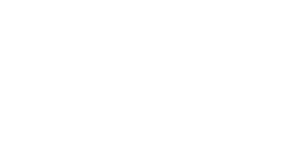

In [28]:
%matplotlib notebook
ax = plt.axes(projection='3d')

xdata = X_world[:, 0]
ydata = X_world[:, 1]
zdata = X_world[:, 2]

ax.scatter3D(xdata, ydata, zdata,c=col_val)
#x = np.array([100, 0])
#y = np.array([100, 100])
#z = np.array([10, 60])
 
# plotting
ax.plot3D([origin[0],x_lim[0] ], [origin[1],x_lim[1] ], [origin[2],x_lim[2] ], color='red')
ax.plot3D([origin[0],y_lim[0] ], [origin[1],y_lim[1] ], [origin[2],y_lim[2] ], color='green')
ax.plot3D([origin[0],z_lim[0] ], [origin[1],z_lim[1] ], [origin[2],z_lim[2] ], color='blue')

In [29]:
M_ext.shape

(4, 4)

In [30]:
transformed_world.shape

(200, 4)

<IPython.core.display.Javascript object>


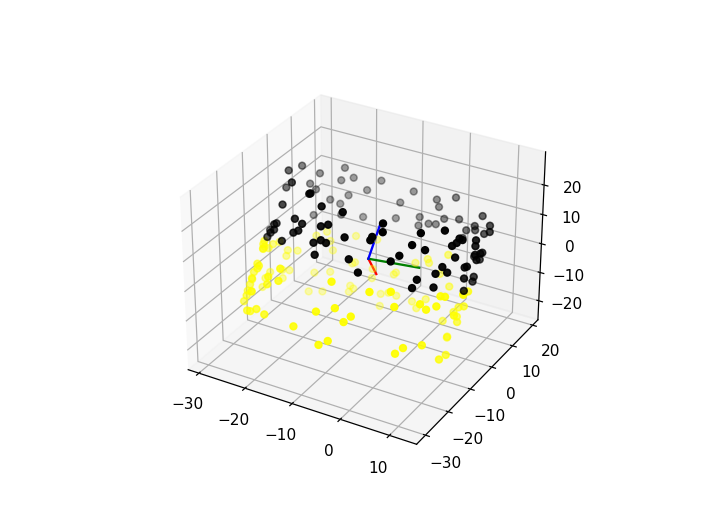

In [31]:
%matplotlib notebook

ax = plt.axes(projection='3d')

xdata = transformed_world[:, 0]
ydata = transformed_world[:, 1]
zdata = transformed_world[:, 2]

ax.scatter3D(xdata, ydata, zdata,c=col_val)
#x = np.array([100, 0])
#y = np.array([100, 100])
#z = np.array([10, 60])
 
# plotting
ax.plot3D([origin[0],x_lim[0] ], [origin[1],x_lim[1] ], [origin[2],x_lim[2] ], color='red')
ax.plot3D([origin[0],y_lim[0] ], [origin[1],y_lim[1] ], [origin[2],y_lim[2] ], color='green')
ax.plot3D([origin[0],z_lim[0] ], [origin[1],z_lim[1] ], [origin[2],z_lim[2] ], color='blue')